<a href="https://colab.research.google.com/github/HananehKoushki/NLP-Assignment/blob/master/SpamClassifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


download dataset from:

https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset

In [5]:
#Load the dataset
df = pd.read_csv('combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In this dataset:
* '1' indicates that the email is classified as spam.
* '0' denotes that the email is legitimate (ham).



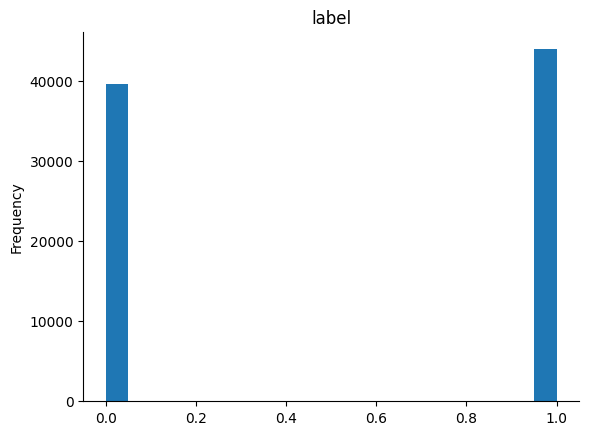

In [6]:
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
# Create a copy of the DataFrame to avoid modifying the original
df_clean = df.copy()

# Function to clean text
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Split into words
    text = [ps.stem(word) for word in text if word not in stopwords('english')]  # Remove stop words and stem
    return ' '.join(text)

# Clean text in the 'emails' column
if not df_clean['text'].dtype == object:  # Check if 'emails' is already a string
    df_clean['text'] = df_clean['emails'].apply(clean_text)

In [8]:
# Separate features (X) and target (y) after cleaning
X = df_clean['text']
y = df_clean['label']  # Assuming 'label' is the target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [10]:
import string
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1662.9527250503309


In [11]:
max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 211745 (827.13 KB)
Trainable params: 211745 (827.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [14]:
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/20
115/115 [==============================] - 528s 4s/step - loss: 0.3396 - accuracy: 0.8508 - val_loss: 0.0970 - val_accuracy: 0.9701
Epoch 2/20
115/115 [==============================] - 515s 4s/step - loss: 0.1087 - accuracy: 0.9648 - val_loss: 0.0827 - val_accuracy: 0.9750
Epoch 3/20
115/115 [==============================] - 521s 5s/step - loss: 0.0579 - accuracy: 0.9834 - val_loss: 0.0668 - val_accuracy: 0.9801
Epoch 4/20
115/115 [==============================] - 518s 5s/step - loss: 0.0471 - accuracy: 0.9871 - val_loss: 0.0696 - val_accuracy: 0.9797
Epoch 5/20
115/115 [==============================] - 511s 4s/step - loss: 0.0535 - accuracy: 0.9848 - val_loss: 0.0806 - val_accuracy: 0.9759
Epoch 6/20
115/115 [==============================] - 520s 5s/step - loss: 0.0538 - accuracy: 0.9851 - val_loss: 0.0776 - val_accuracy: 0.9773
Epoch 7/20
115/115 [==============================] - 523s 5s/step - loss: 0.0387 - accuracy: 0.9896 - val_loss: 0.0705 - val_accuracy: 0.9805

In [15]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

783/783 [==============================] - 95s 120ms/step


In [16]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns

cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()

print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))
from sklearn.metrics import accuracy_score
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test_encoded, y_predict)))

Precision: 98.09%
Recall: 98.46%
F1 Score: 98.27%
Accuracy: 98.18%


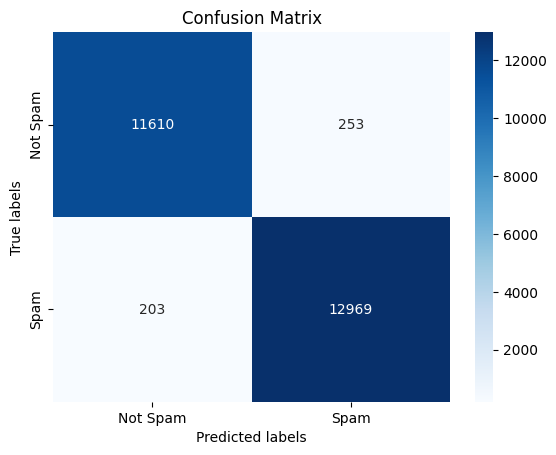

In [17]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);